# Увеличение числа деревьев в бэггинге и бустинге

### Модельный пример

Продемонстрируем это сравнение на простом модельном примере.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Text(0,0.5,'Target y')

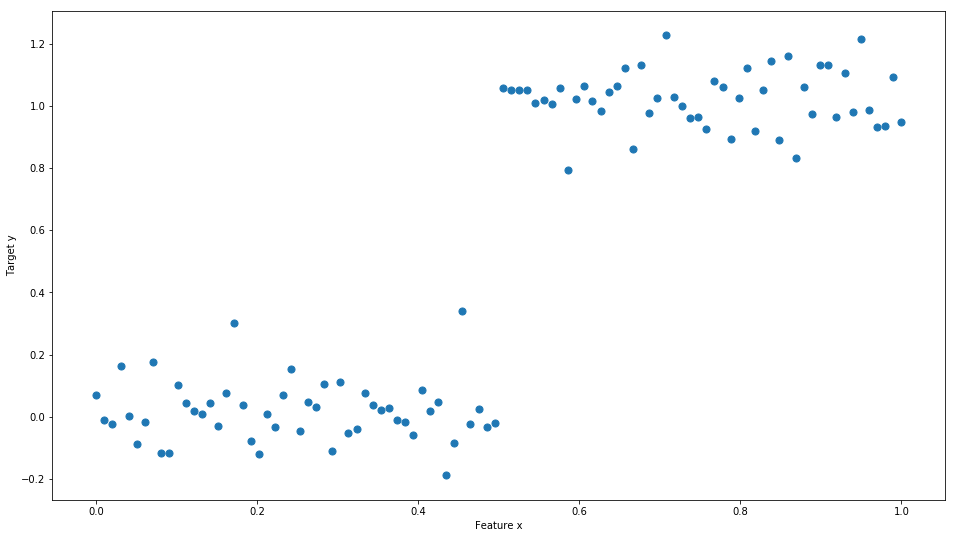

In [5]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

plt.xlabel('Feature x')
plt.ylabel("Target y")

Обучим на нем большое количество решающих деревьев бэггингом. Для наглядности на графиках используем неравномерный шаг по количеству деревьев.

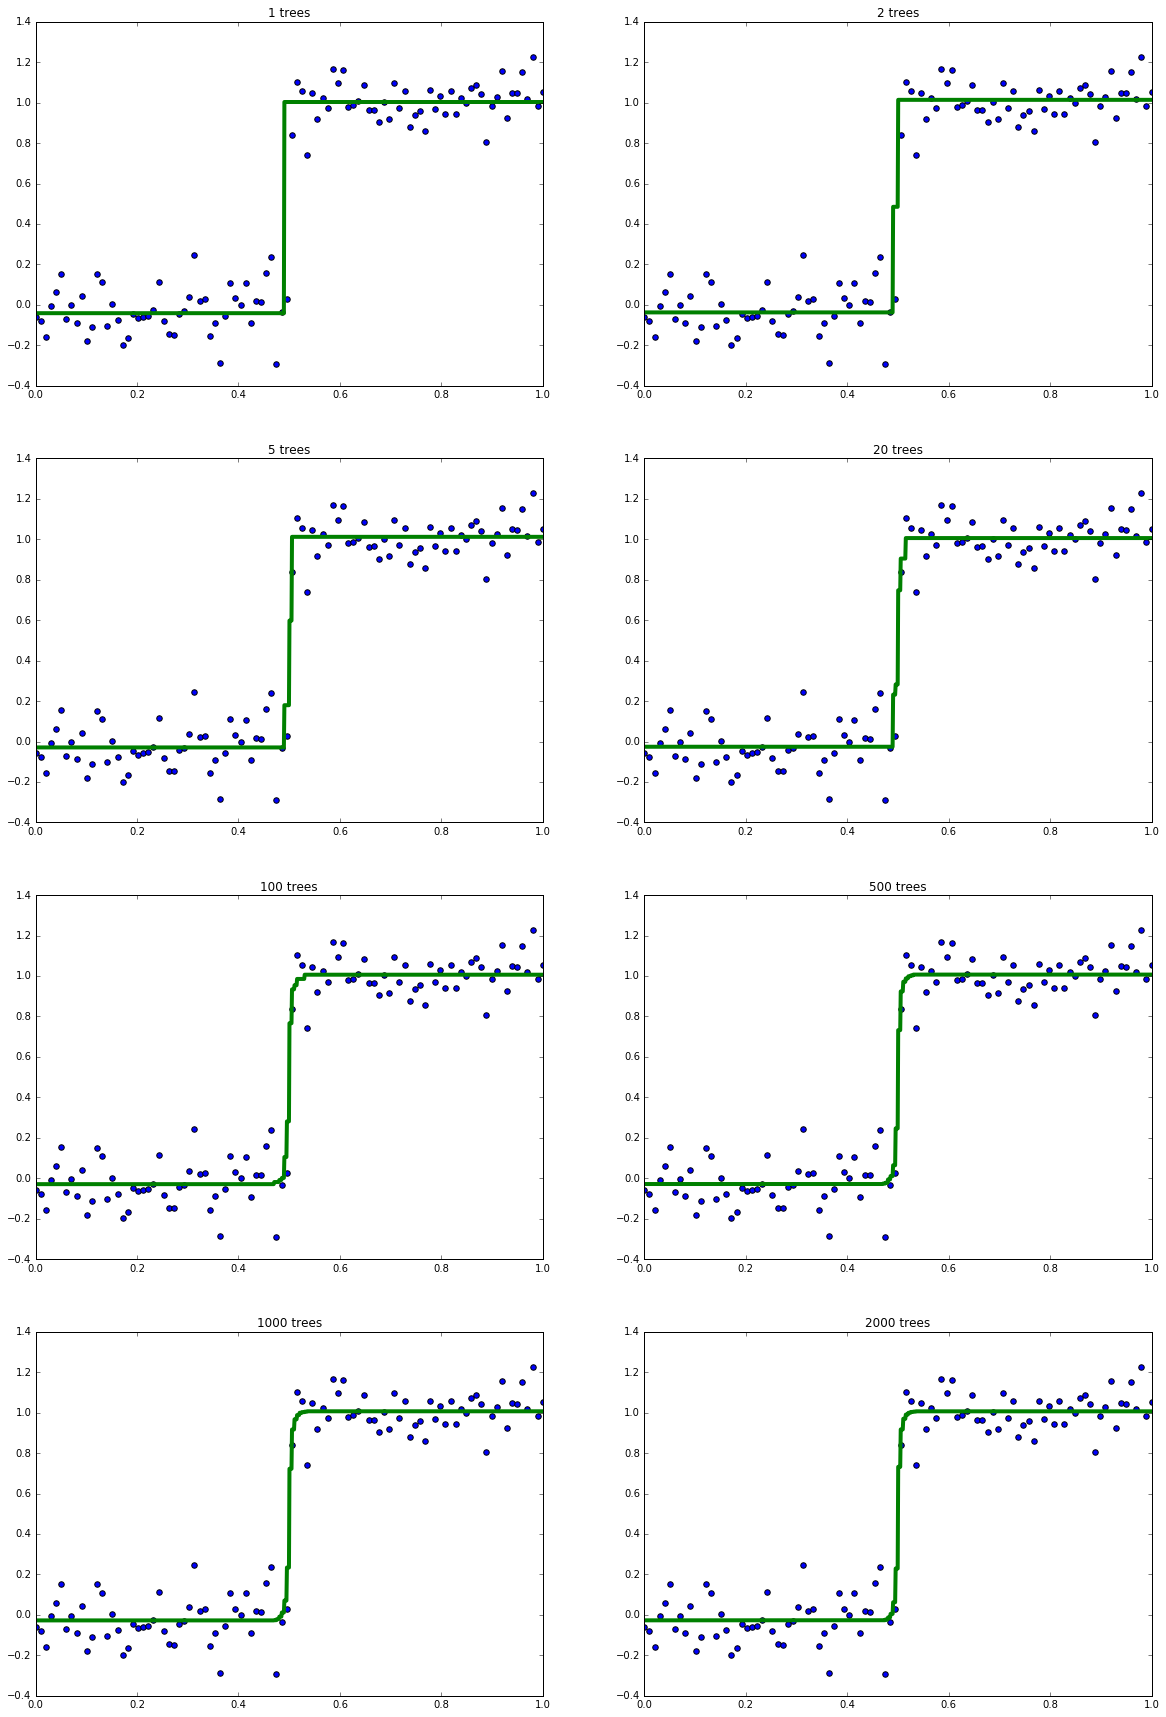

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=1), \
                       warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

Теперь проделаем то же самое для градинентного бустинга.

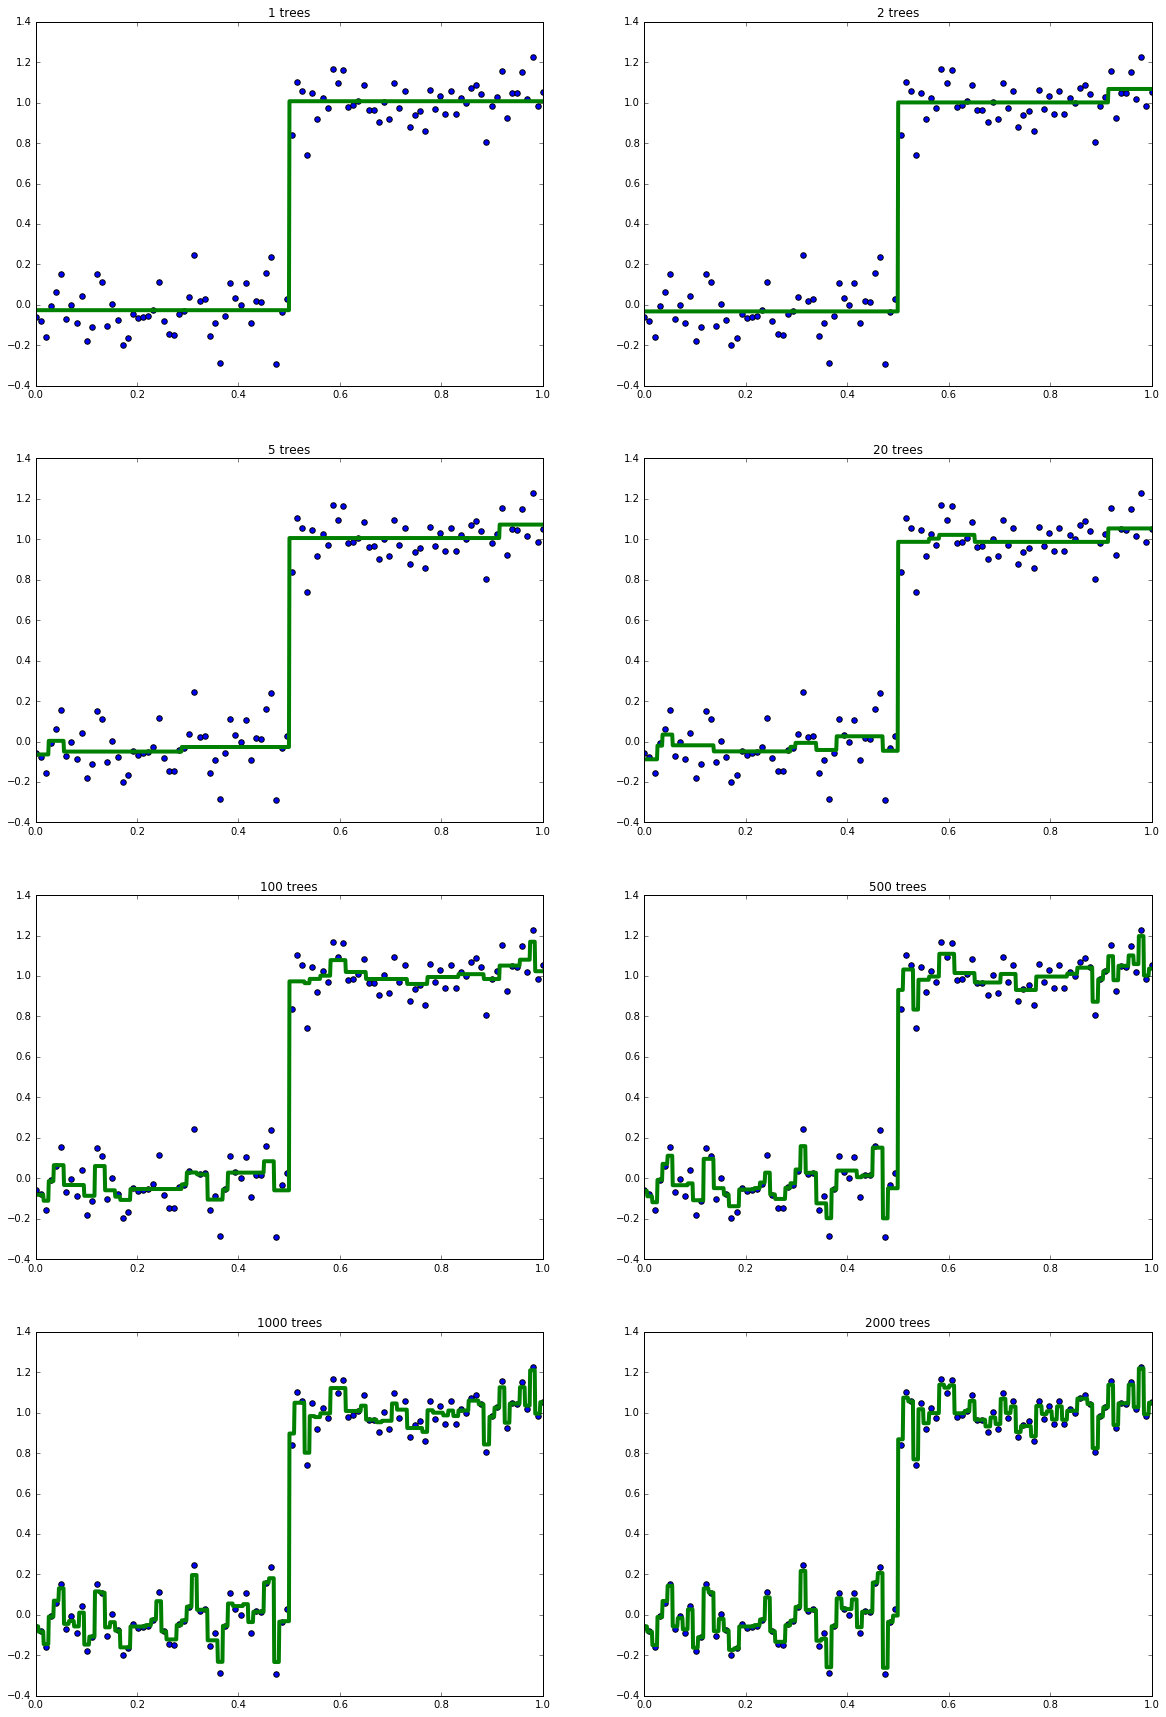

In [4]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего сильно переобучился.


Бороться с этой проблемой можно с помощью выбора очень простого базового алгоритма или
же искусственным снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

Такая поправка замедляет обучение по сравнению с бэггингом, но зато позволяет получить менее переобученный алгоритм. Тем не менее, важно понимать, что переобучение всё равно будет иметь место при обучении сколь угодно большого количества базовых алгоритмов для фиксированного $\eta$.

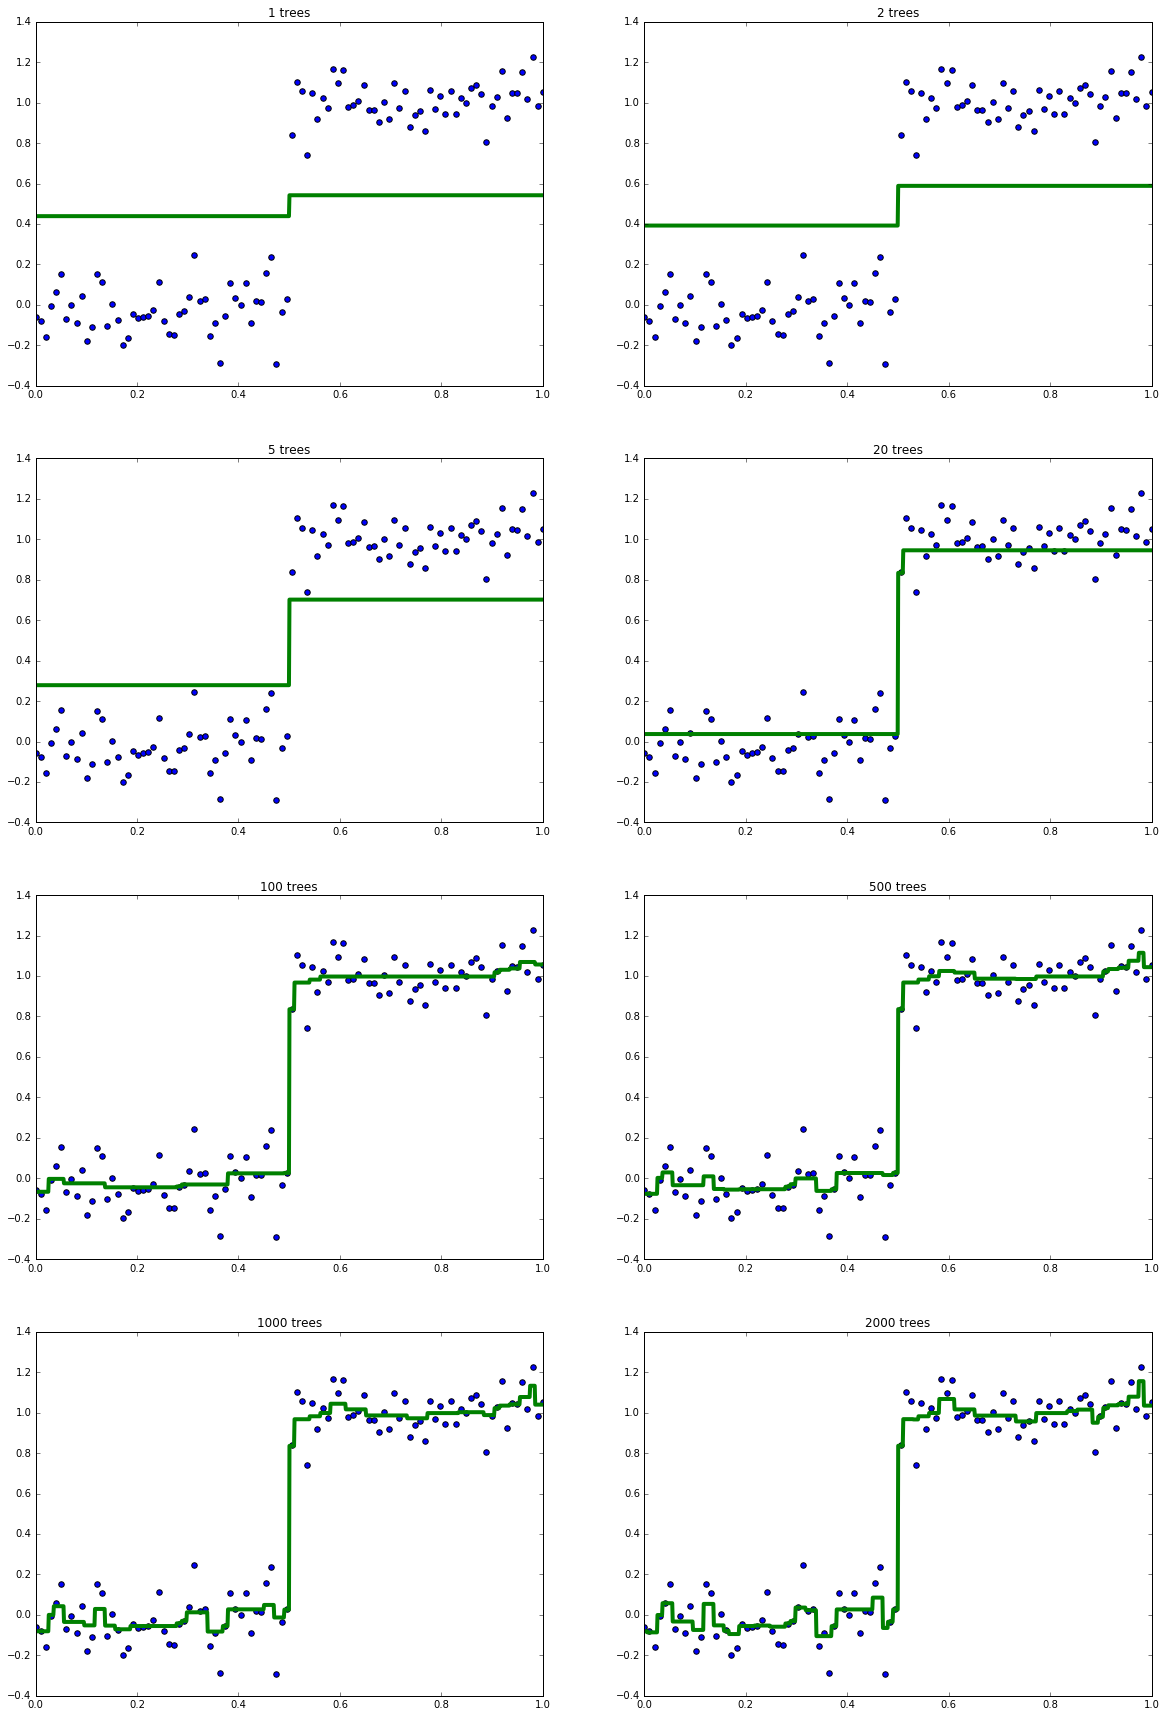

In [5]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

### Реальные данные

In [6]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5)

MAX_ESTIMATORS = 250

gbclf = GradientBoostingRegressor(warm_start=True)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))

/Users/user/anaconda3/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Text(0,0.5,'1-R^2')

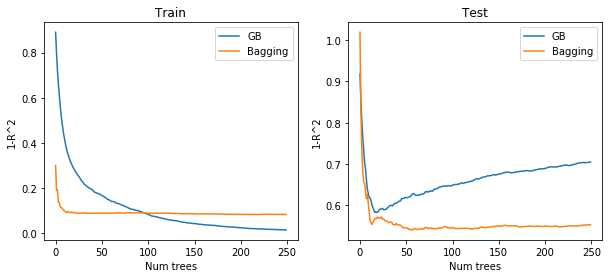

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.xlabel("Num trees")
plt.ylabel("1-R^2")
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')
plt.xlabel("Num trees")
plt.ylabel("1-R^2")